## Tutorial for training ML models with nanopore data for site-specific ψ quantification

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns
import sys
import os
import pandas as pd
from sklearn import preprocessing
import sklearn as sk
import scipy
print('The numpy version is {}.'.format(np.__version__))
print('The scikit-learn version is {}.'.format(sk.__version__))
print('The pandas version is {}.'.format(pd.__version__))
print('The scipy version is {}.'.format(scipy.__version__))
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix


from sklearn.metrics import RocCurveDisplay
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from matplotlib import colors
print("######")
#from ModQuant import ML_helpers 
import ML_helpers 

The numpy version is 1.23.5.
The scikit-learn version is 1.1.1.
The pandas version is 1.4.2.
The scipy version is 1.10.0.
######
The numpy version is 1.23.5.
The scikit-learn version is 1.1.1.
The pandas version is 1.4.2.
The scipy version is 1.10.0.
The python version is 3.8.16 (default, Jan 17 2023, 22:25:28) [MSC v.1916 64 bit (AMD64)].
The scikit-learn version is 1.1.1.
The numpy version is 1.23.5.
The pandas version is 1.4.2.


### Let's load a dataframe containing the training set extracted from synthetic standards called with guppy 6.3.2 with a +2/-2 feature extraction window

In [2]:
df=pd.read_pickle("prepared_training_data/MCM5_training_data_with_insertions_6.3.2_n5_11282022_141230.pkl")#MCM5
#df=pd.read_pickle("ModQuant/prepared_training_data/MRPS14_training_data_with_insertions_6.3.2_n5_11282022_14932.pkl")#MRPS14
#df=pd.read_pickle("ModQuant/prepared_training_data/PRPSAP1_training_data_with_insertions_6.3.2_n5_11282022_141510.pkl")#PRPSAP1
#df=pd.read_pickle("ModQuant/prepared_training_data/PSMB2_training_data_with_insertions_6.3.2_n5_11282022_14178.pkl")#PSMB2
#df=pd.read_pickle("ModQuant/prepared_training_data/RNF7_training_data_with_insertions_6.3.2_n5_11282022_142012.pkl")#RNF7


### Let's drop prepare the feature space for ML training and testing

In [3]:
for (columnName, columnData) in df.iteritems(): #Let's take a look at the feature names in our dataframe
    print('Column Name : ',columnName)


substrings_to_drop=['read_ID','samples','type'] #dropping columns from the dataframe that should not be in the feature space
columns_to_drop=[col for col in df.columns if any(substring in col for substring in substrings_to_drop)]

feature_prep_df=df.drop(columns=columns_to_drop)

feature_space=[]
for (columnName,columnData) in feature_prep_df.iteritems():
    print('Column Name : ', columnName)
    feature_space.append(columnName)
print(f"Number of feature dimensions: {len(feature_space)}")

print(df["type"].value_counts())


Column Name :  read_ID
Column Name :  B.n2
Column Name :  B.n1
Column Name :  B.0
Column Name :  B.p1
Column Name :  B.p2
Column Name :  Q.n2
Column Name :  Q.n1
Column Name :  Q.0
Column Name :  Q.p1
Column Name :  Q.p2
Column Name :  Insertions_Freq_A
Column Name :  Insertions_Freq_C
Column Name :  Insertions_Freq_G
Column Name :  Insertions_Freq_T
Column Name :  Total_Insertions
Column Name :  signal.mean.n2
Column Name :  signal.mean.n1
Column Name :  signal.mean.0
Column Name :  signal.mean.p1
Column Name :  signal.mean.p2
Column Name :  signal.std.n2
Column Name :  signal.std.n1
Column Name :  signal.std.0
Column Name :  signal.std.p1
Column Name :  signal.std.p2
Column Name :  signal.dt.n2
Column Name :  signal.dt.n1
Column Name :  signal.dt.0
Column Name :  signal.dt.p1
Column Name :  signal.dt.p2
Column Name :  raw.current.samples.n2
Column Name :  raw.current.samples.n1
Column Name :  raw.current.samples.0
Column Name :  raw.current.samples.p1
Column Name :  raw.current.sampl

### Let's now train and test all five supervised models with stratified 5-fold cross-validation

In [7]:
#Plotting Function for confusion matrix
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm

def plot_avg_conf_mat(ax,mat_mean,mat_std,avg_accuracy,labels,color):
    plusminus = u"\u00B1"
    ax.grid(False)
    cax = ax.matshow(mat_mean, cmap=matplotlib.cm.get_cmap(color),vmin=0,vmax=1)
    for k in range(mat_mean.shape[0]):
        for j in range(mat_mean.shape[1]):
            if k == j:
                textcolor='white'
            else:
                textcolor='k'
            ax.text(x=j, y=k,s=f"{100*mat_mean[k, j]:0.1f}{plusminus}{100*mat_std[k, j]:0.2f}%", va='center', ha='center', size='x-large', color=textcolor)
    ax.set_title(f"Mean Classification Accuracy: {avg_accuracy*100:.1f} %")
    ax.xaxis.tick_bottom()
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels, rotation="vertical",verticalalignment='center')
    plt.xlabel("Predicted")
    plt.ylabel("Expected")
    return

Overall accuracy of gbc: 0.9720185245486451
Overall accuracy of rfc: 0.9504775860197546
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Overall accuracy of svm: 0.967630341184558
Overall accuracy of logisticReg: 0.953548789753609
Overall accuracy of knn: 0.943320670067658


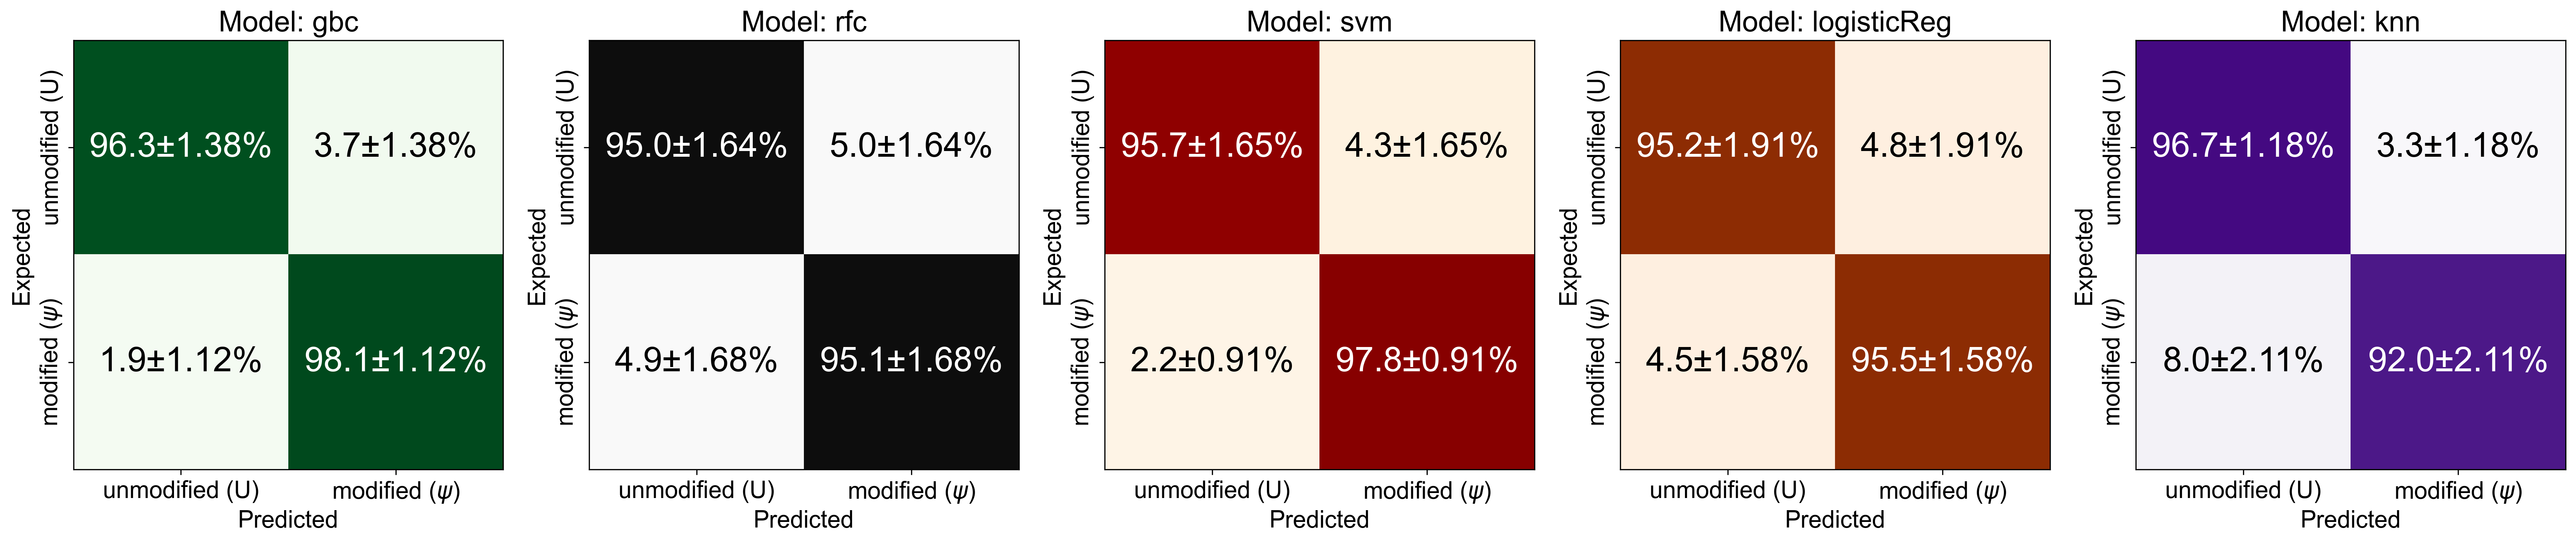

In [8]:
import warnings
warnings.filterwarnings('ignore')
disp_labels = ["unmodified (U)", "modified ($\psi$)"]
plt.rcParams['font.family'] = "arial"
matplotlib.rcParams.update({'font.size':16})


models=['gbc','rfc','svm','logisticReg','knn'] #load models we want to train and test
colors = ['Greens', 'Greys', 'OrRd', 'Oranges', 'Purples'] #colors of confusion matrix displaying overall accuracy for each model
labels=["unmodified","modified"] #labels we used in 'type' column to identify if a transcript is modified or unmodified

plt.figure(figsize=(30,10), dpi=300)
for idx, model in enumerate(models):
    ax=plt.subplot(1, 5, idx+1)
    summary_output=ML_helpers.IterateModel(df,feature_space,labels,model,seed=654).model_iter() #train and test each model iteratively
    print(f"Overall accuracy of {model}: {summary_output['avg_accuracy']}")
    plot_avg_conf_mat(ax,summary_output['avg_conf_mat_mean'],summary_output['avg_conf_mat_std'],summary_output['avg_accuracy'],disp_labels,colors[idx])
    plt.title(f"Model: {model}") #comment this out to print the overall accuracy as the title of each confusion matrix
    

### Let's now look at the accuracy of the GBC model as a function of training size

In [5]:
###Training and testing gbc model at varying sample sizes in the training set to see the overall accuracy as a function of sample size of training data###
import math

labels=["unmodified","modified"] #labels we used in 'type' column to identify if a transcript is modified or unmodified
print(f"Sample size of each type in the original training:\n{df['type'].value_counts()}")
limiting_total_size=min(df["type"].value_counts()) #Let's take the sample size of the modified data and limit our analysis to it
limiting_train_size=math.floor(limiting_total_size*0.8) #we need to save 20% of the data for testing at the maximum training size
 
model='gbc'
#model_typec='rfc'
#model_type='svm'
#model_type='logisticReg'
#model_type='knn'

s_max_log=np.log10(limiting_train_size) #log-scale the maximum training size for each sample at the end of our sweep

total_accuracy=[]
sample_sizes=np.logspace(1.5,s_max_log,25,endpoint=True) 
for sz in sample_sizes:
    sz=math.floor(sz)
    print('')
    print(f"Training sample size for each type of sample for this iteration: {sz}")
    summary_output=ML_helpers.IterateModel(df,feature_space,labels,model,seed=4321,train_sample_sz=sz).model_iter() #train and test each model iteratively
    #summary_output=model_iter(df,Syn_List,model_type,4321,0.2,5,5,25,sz) #MCM5, PSMB2
    #summary_output=model_iter(df,Syn_List,model_type,654,0.2,5,5,25,sz) #MRPS14, PRPSAP1, RNF7
    #training_sz=len(summary_output["iteration_results"][0]['x_train'])
    training_sz=len(summary_output["iteration_results"][0]['x_train'])
    test_sz=len(summary_output["test_indices"][0])
    print(f"Confirmed input training size used for these model iterations: {training_sz}")
    print(f"Confirmed input test size used for these model iterations: {test_sz}")
    print(f"Average GBC accuracy with current: {summary_output['avg_accuracy']}")
    total_accuracy.append((training_sz,summary_output["avg_accuracy"],summary_output["std_accuracy"])) #append results to list to plot
print(total_accuracy)

Sample size of each type in the original training:
unmodified    8947
modified       831
Name: type, dtype: int64

Training sample size for each type of sample for this iteration: 31
Confirmed input training size used for these model iterations: 62
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.833991461340859

Training sample size for each type of sample for this iteration: 35
Confirmed input training size used for these model iterations: 70
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.8386938745974889

Training sample size for each type of sample for this iteration: 40
Confirmed input training size used for these model iterations: 80
Confirmed input test size used for these model iterations: 333
Average GBC accuracy with current: 0.8446439813307284

Training sample size for each type of sample for this iteration: 46
Confirmed input training size used for these model iterations:

### Let's plot the results from sweeping the training size of the GBC model

[  57.  581. 1104. 1628.]


Text(0.5, 1.0, 'GBC model accuracy versus sample size of training data for $\\itMCM5$')

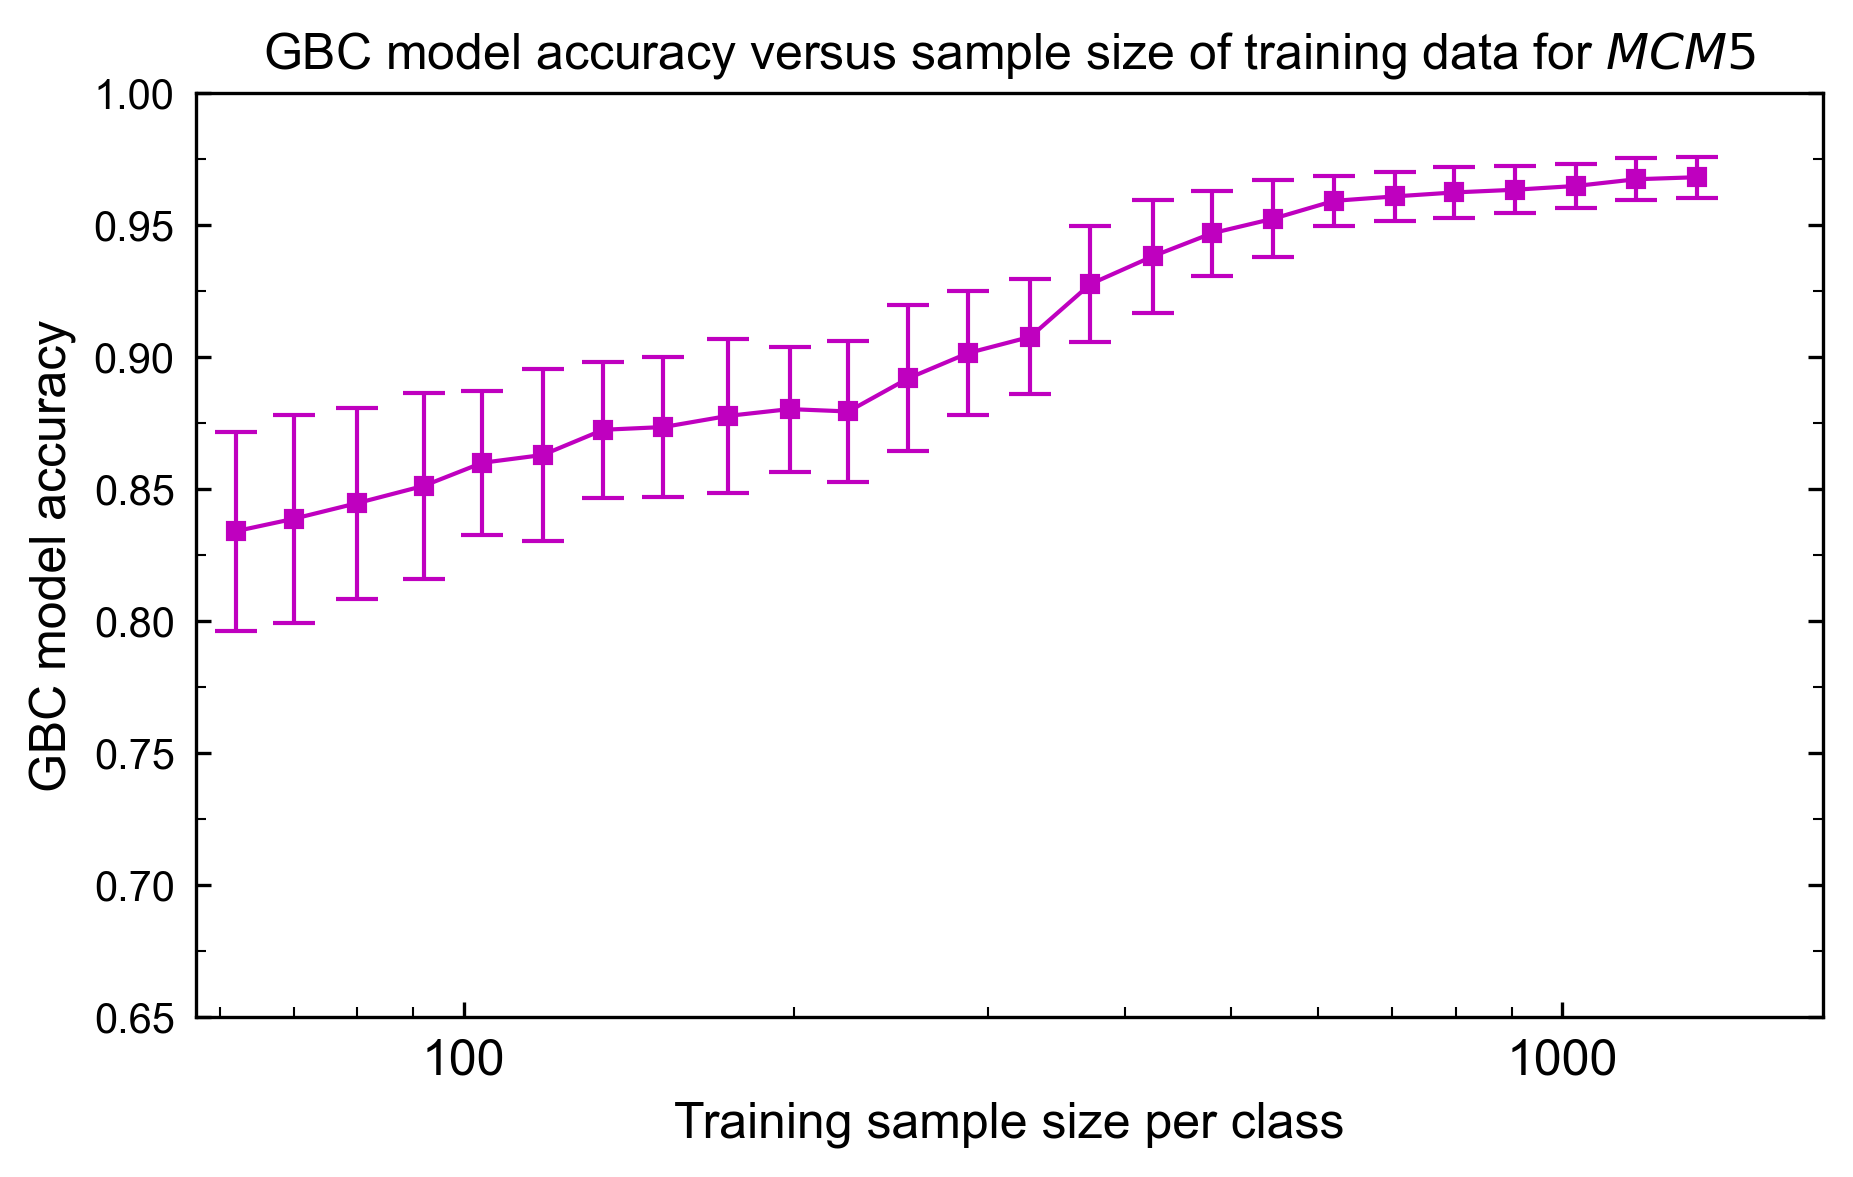

In [9]:
####Plotting model accuracy as a function of sample size for training and testing####
from sklearn.metrics import RocCurveDisplay
import seaborn as sns
from matplotlib import gridspec
import matplotlib.patches as mpatches
import matplotlib.font_manager
from matplotlib.ticker import AutoMinorLocator
from matplotlib.ticker import MultipleLocator
import pickle
import warnings
warnings.filterwarnings('ignore')

#gene = 'PRPSAP1'
#gene = 'PSMB2'
gene = 'MCM5'
#gene = 'MRPS14'
#gene = 'RNF7'


sample_sizes=([i[0] for i in total_accuracy])
sample_means=([i[1] for i in total_accuracy])
sample_stds=([i[2] for i in total_accuracy])

plt.rcParams['font.family'] = "arial"
fig, ax = plt.subplots(figsize=(7,4),dpi=300)
ax.yaxis.set_ticks_position('both')
ax.tick_params(axis="y",direction="in", pad=5)
ax.tick_params(axis="x",direction="in", pad=5)
minor_locator_x = AutoMinorLocator(2)
minor_locator_y = AutoMinorLocator(2)
ax.tick_params(which='minor', length=2.5, width=0.5, direction='in')
ax.xaxis.set_minor_locator(minor_locator_x)
ax.yaxis.set_minor_locator(minor_locator_y)
ax.set_ylim([0.65, 1])
ax.set_xlim([sample_sizes[0]-5, sample_sizes[-1]+400])


xlo=sample_sizes[0]-5
xhi=sample_sizes[-1]+300
x_ticks = np.linspace(xlo,xhi,4)
x_ticks = np.around(x_ticks)

print(x_ticks)
ax.set_xscale('log')
ax.set_xticklabels([str(int(x_ticks[0])),str(int(x_ticks[1])),str(int(x_ticks[2])),str(int(x_ticks[3]))], fontdict = {'fontsize' : 12})
ax.set_xlabel('Training sample size per class', fontdict = {'fontsize' : 12})
ax.set_ylabel('GBC model accuracy', fontdict = {'fontsize' : 12})

ax.set_xticklabels(['0', '1', '100', '1000'], fontdict = {'fontsize' : 12})#for MCM5 and MRPS14 and PRPSAP1
model_vs_samplesz=ax.errorbar(sample_sizes,sample_means,yerr=sample_stds,fmt='s',solid_capstyle='projecting', 
                               capsize=5,color='m',linestyle='-',lw=1, markersize=4,elinewidth=1, label=f"Target Features Only")
ax.set_title(f'GBC model accuracy versus sample size of training data for $\it{gene}$', fontdict = {'fontsize' : 12})